<a href="https://colab.research.google.com/github/sheemambabu/CMPE-258-Deep-Learning/blob/main/Assignment%203/HW_3_PartB_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE-258 Deep Learning
## Homework 3
### By,
### Sheema Murugesh Babu (SJSU-ID: 015217176)



Part b.2) Using pure pytorch tensor data structure to build the same but with auto differentiation primitives.

# Using pure pytorch:

In [ ]:
import torch as tr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error

# Generating sample data: 

In [ ]:
n_samples = 200
input_dimensions = 3
output_dimensions = 2

tr.manual_seed(123)
max = 1
min = -1
X = (max - min) * tr.rand((n_samples, input_dimensions)) + min
print('Samples values of x:', X[:3])

weights_true = tr.tensor([[5., 1., -5.], [-1., -8., 1.]])
bias_true = tr.tensor([[1.], [1.]])

y_true = (-6 * X ** 2) @ weights_true.T + X @ weights_true.T + bias_true.T

print('Samples values of y:', y_true[:3])
print(f'X: {X.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

Samples values of x: tensor([[-0.4078,  0.0331, -0.4967],
        [ 0.3771, -0.8521,  0.7330],
        [-0.7268, -0.7950, -0.6319]])
Samples values of y: tensor([[ 3.8826,  0.2165],
        [ 5.8665, 40.6494],
        [-7.9328, 38.5698]])
X: torch.Size([200, 3]), weights: torch.Size([2, 3]), bias: torch.Size([2, 1]), y: torch.Size([200, 2])


# Function plot 3-D data with sklearn TSNE


In [ ]:
def plot_3d(title, X, y, y_pred=None):
  X_tsne = TSNE(n_components = 2, random_state=123).fit_transform(X)

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_tsne[:, 0], X_tsne[:, 1], y, label='y_true')
  ax.set_title(title)
  if y_pred is not None:
     ax.scatter(X_tsne[:, 0], X_tsne[:, 1], y_pred, label='y_pred', marker = '^')
  plt.legend()
  plt.show()

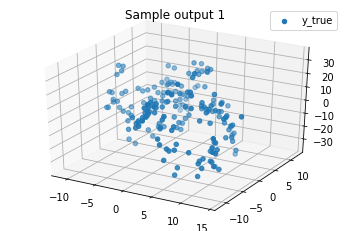

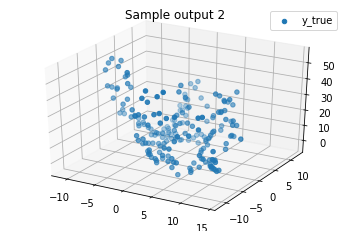

In [ ]:
plot_3d('Sample output 1', X, y_true[:,0])
plot_3d('Sample output 2', X, y_true[:,1])

# Building a neural network from scratch


In [ ]:
# Mean Squared Error
class MSE:
  def __init__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
  
  def get_error(self):
    n = self.y_true.shape[0]
    return ((self.y_pred - self.y_true) ** 2) / n
  
  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2.0 * (self.y_pred - self.y_true) / n
    return self.gradient


In [ ]:
# Relu Activation layer

class Relu:
  def __init__(self):
    self.input = tr.tensor([])

  def forward(self, input):
    self.input = input
    self.output = tr.clamp(self.input, min=0)
    return self.output
  
  # Backward is not needed for activation function since auto differentiation takes care of this.
  def backward(self, upstr_gradient):
    return 
  
  # No update needed to ReLU members
  def update(self, lr):
    return

  def __str__(self):
    return 'ReLu'

In [ ]:
class Layer:
  def __init__(self, n_input_nodes=1, n_output_nodes=1, activation_func=None):
    self.n_input_nodes = n_input_nodes
    self.n_output_nodes = n_output_nodes

    # Init layer with random weights and bias
    self.weights = (max - min) * tr.rand((n_input_nodes, n_output_nodes), requires_grad=True) + min
    self.bias = tr.rand((1), requires_grad=True)
    self.X = tr.ones([n_input_nodes])

    # Setting the activation function
    if activation_func == 'relu':
      self.activation_func = Relu()
    else: 
      self.activation_func = None
  
  def forward(self, X):
    self.X = X
    self.Z = X @ self.weights + self.bias
    self.weights.retain_grad()
    self.bias.retain_grad()
    # Passing the output to activation function
    if self.activation_func == None:
      return self.Z 
    else:
      return self.activation_func.forward(self.Z)

  def backward(self):
    self.dJdW = self.weights.grad
    self.dJdb = self.bias.grad

  # Updating the weight and bias params with learning rate step size
  def update(self, lr):
    self.weights = self.weights - lr * self.dJdW
    self.bias = self.bias - lr * self.dJdb

  def __str__(self):
    return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{} \nWeights:\n{} \nBias:{}'.format(self.n_input_nodes, self.n_output_nodes, self.activation_func, self.X[:2], 
            self.weights, self.bias)

In [ ]:
class NeuralNetwork_Model:
  def __init__(self, n_inputs=3, n_hidden=[2], n_outputs=2, activation_func=None):
    self.n_inputs = n_inputs
    self.n_hidden = n_hidden
    self.n_outputs = n_outputs

    layers = [self.n_inputs] + self.n_hidden + [self.n_outputs]
    
    self.layers = []
    for i in range(len(layers[:-1])):
      # Not adding the activation function to last layer because it is a regression problem
      if i == len(layers[:-1]) - 1:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func=None))
      else:
        self.layers.append(Layer(layers[i], layers[i + 1], activation_func))

    # Printing the network architecture
    print('Neural Network Architecture:')
    for i, layer in enumerate(self.layers):
      print('---------------------- Layer {} ----------------------'.format(i))
      print(layer)
    print()

  def forward(self, inputs):
    current_output = inputs
    for l in self.layers:
      current_output = l.forward(current_output)
    return current_output
  
  def backward(self, y_pred, y_true):
    ext_grad = tr.ones(y_true.shape)
    # Starting with the gradient from loss function with repect to prediction
    mse = MSE(y_pred, y_true)
    error = mse.get_error()
    print('MSE: ', mean_squared_error(y_true, y_pred.detach().numpy()))
    error.backward(gradient=ext_grad, retain_graph=True)

    for layer in reversed(self.layers):
      layer.backward()
    
  def update(self, lr):
    for layer in self.layers:
      layer.update(lr)
  
  # Training loop over number of epochs
  def fit(self, X, y_true, epochs):
    for i in range(epochs):
      y_pred = self.forward(X)
      self.backward(y_pred, y_true)
      self.update(lr)

  def __str__(self):
    s = [str(layer) for layer in self.layers]
    return '\n'.join(s)

# Hyperparameters

In [ ]:
# Number of Iterations
epochs = 280

# Learning rate of the algorithm
lr = 0.01

# Input and output size. i.e 3 and 2 relatively
input = X.shape[1]
output = y_true.shape[1]

print(input)
print(output)

3
2


# Training the Neural Network model with ReLU activation function

In [ ]:
model = NeuralNetwork_Model(n_inputs=input, n_hidden=[4, 3], n_outputs=output, activation_func='relu')
model.fit(X, y_true, epochs)
y_pred = model.forward(X).detach().numpy()

err = mean_squared_error(y_true, y_pred)
print('Final MSE with ReLU: {}'.format(err))

Neural Network Architecture:
---------------------- Layer 0 ----------------------
Layer: (3,4) Activation Function: ReLu
Inputs:
tensor([1., 1.]) 
Weights:
tensor([[-0.6070, -0.8011,  0.2464,  0.1816],
        [ 0.9616,  0.9695,  0.4290,  0.5923],
        [ 0.4552, -0.0746, -0.9362, -0.3961]], grad_fn=<AddBackward0>) 
Bias:tensor([0.0755], requires_grad=True)
---------------------- Layer 1 ----------------------
Layer: (4,3) Activation Function: ReLu
Inputs:
tensor([1., 1.]) 
Weights:
tensor([[ 0.7103, -0.5405, -0.7885],
        [-0.1312,  0.6801,  0.4372],
        [ 0.3658, -0.0609, -0.9142],
        [-0.5927, -0.8457, -0.2984]], grad_fn=<AddBackward0>) 
Bias:tensor([0.8447], requires_grad=True)
---------------------- Layer 2 ----------------------
Layer: (3,2) Activation Function: None
Inputs:
tensor([1., 1.]) 
Weights:
tensor([[-0.6631, -0.2573],
        [ 0.9815,  0.6870],
        [ 0.3635,  0.6353]], grad_fn=<AddBackward0>) 
Bias:tensor([0.3984], requires_grad=True)

MSE:  320.47

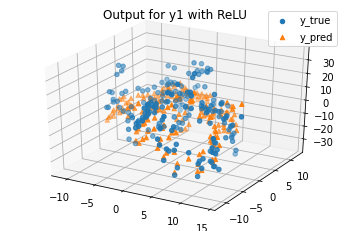

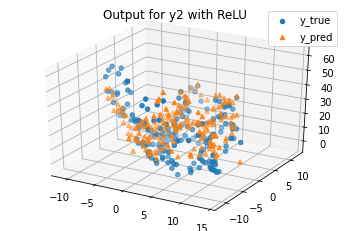

In [ ]:
plot_3d('Output for y1 with ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2 with ReLU', X, y_true[:,1], y_pred[:,1])

# Training the Neural Network model without ReLU activation function

In [ ]:
model = NeuralNetwork_Model(n_inputs=input, n_hidden=[4, 3], n_outputs=output, activation_func=None)
model.fit(X, y_true, epochs)
y_pred = model.forward(X).detach().numpy()

err = mean_squared_error(y_true, y_pred)
print('Final MSE without ReLU: {}'.format(err))

Neural Network Architecture:
---------------------- Layer 0 ----------------------
Layer: (3,4) Activation Function: None
Inputs:
tensor([1., 1.]) 
Weights:
tensor([[-0.5369,  0.5052,  0.2697, -0.3102],
        [ 0.7715, -0.7126, -0.0211,  0.8085],
        [ 0.3218, -0.7848,  0.1627, -0.1430]], grad_fn=<AddBackward0>) 
Bias:tensor([0.7065], requires_grad=True)
---------------------- Layer 1 ----------------------
Layer: (4,3) Activation Function: None
Inputs:
tensor([1., 1.]) 
Weights:
tensor([[ 0.5632, -0.7078, -0.3293],
        [ 0.8310, -0.7292, -0.2267],
        [-0.3330, -0.2446, -0.1376],
        [ 0.5742,  0.6249, -0.3583]], grad_fn=<AddBackward0>) 
Bias:tensor([0.5582], requires_grad=True)
---------------------- Layer 2 ----------------------
Layer: (3,2) Activation Function: None
Inputs:
tensor([1., 1.]) 
Weights:
tensor([[-0.9277, -0.3777],
        [-0.0935, -0.0363],
        [ 0.1825,  0.0549]], grad_fn=<AddBackward0>) 
Bias:tensor([0.3513], requires_grad=True)

MSE:  340.59

From the above, we can see that the error is larger when ReLU activation is not applied.

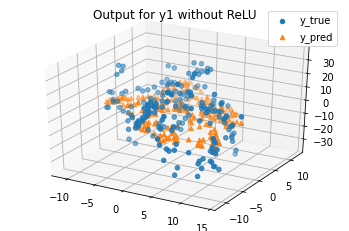

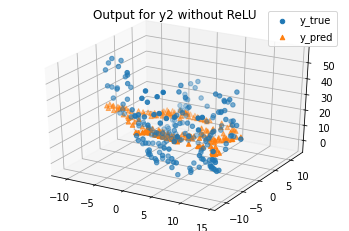

In [ ]:
plot_3d('Output for y1 without ReLU', X, y_true[:,0], y_pred[:,0])
plot_3d('Output for y2 without ReLU', X, y_true[:,1], y_pred[:,1])

## References :

1) Class Slides <br>
2) https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9 <br>
3) https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html <br>
4) https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html